# Solution to exercises week 43-44
#### Brage Wiseth, Eirik Jahr, Felix Cameren

In [338]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)


jax backend gpu


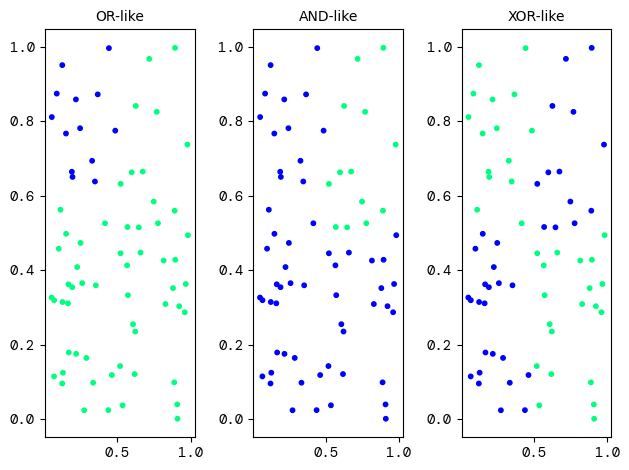

In [339]:
# we can generate a OR-like , AND-like and XOR-like dataset with float values
x = jax.random.uniform(key, shape=(70,2), minval=0, maxval=1)

t_or = (x[:,0] >= 0.5) | (x[:,1] < 0.6)
t_and = (x[:,0] >= 0.5) & (x[:,1] > 0.5)
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)


fig, ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0],x[:,1], s=10, c=t_or, cmap='winter')
ax[0].set_title("OR-like", font='sans')
ax[1].scatter(x[:,0],x[:,1], s=10, c=t_and, cmap='winter')
ax[1].set_title("AND-like", font='sans')
ax[2].scatter(x[:,0],x[:,1], s=10, c=t_xor, cmap='winter')
ax[2].set_title("XOR-like", font='sans')
fig.tight_layout()
plt.show()


In [340]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler() # not using it for now

X_train, X_test, t_or_train, t_or_test = train_test_split(x, t_or, test_size=0.2, random_state=1234)
# same seed so we only need x_train and x_test from the first split
_ , _,   t_and_train , t_and_test = train_test_split(x, t_and, test_size=0.2, random_state=1234)
_ , _,   t_xor_train , t_xor_test = train_test_split(x, t_xor, test_size=0.2, random_state=1234)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

t_or_train = np.asarray(t_or_train).reshape(-1, 1)
t_or_test = np.asarray(t_or_test).reshape(-1, 1)
t_and_train = np.asarray(t_and_train).reshape(-1, 1)
t_and_test = np.asarray(t_and_test).reshape(-1, 1)
t_xor_train = np.asarray(t_xor_train).reshape(-1, 1)
t_xor_test = np.asarray(t_xor_test).reshape(-1, 1)


### ADAMLL is a local library for machine learning algorithms it contains activation functions, cost functions, and optimization algorithms from previous exercises.

In [341]:
import ADAMLL as ada



# sigmoid activation at every layer
def forward_propagate(network, inputs):
    activations = [inputs] # List to hold all activations, layer by layer
    for layer in network:
        net_input = np.dot(activations[-1], layer['w']) + layer['b']
        activations.append(ada.activations.sigmoid(net_input))
    return activations



# cross entropy loss with sigmoid
# TODO: make a more general backpropagate function
def backprop_one_hidden( params, t, activations):
    X, a0, a1 = activations
    output_error = (a1 - t)
    hidden_error =  output_error @ params[1]['w'].T * a0 * (1 - a0) 

    gw0 = X.T @ hidden_error
    gb0 = np.sum(hidden_error, axis=0)
    gw1 = a0.T @ output_error
    gb1 = np.sum(output_error, axis=0)
    gw0, gb0, gw1, gb1 = jax.tree_map(lambda p: p / X.shape[0], (gw0, gb0, gw1, gb1))
    return [{'w': gw0, 'b': gb0}, {'w': gw1, 'b': gb1}]



def single_layer_gradients(_, t, activations ):
    X, y = activations
    wgrad = (2/X.shape[0]) * np.dot(X.T , (y - t))
    bgrad = 2/X.shape[0] * np.sum(y - t)
    return [{'w': wgrad, 'b': bgrad}]

In [342]:




loss = ada.CE
backwards = backprop_one_hidden
forward = forward_propagate




class NN():

    def __init__(self ,architecture=[[2, 2, 1], [ada.activations.sigmoid , None ]],
                eta=0.1, epochs=100, tol=0.001, optimizer='sgd', alpha=0,
                 gamma=0, epsilon=0.0001, decay=0.9, beta1=0.9, beta2=0.999,):
        self.eta = eta
        self.epochs = epochs
        self.tol = tol
        self.optimizer = optimizer
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.architecture = architecture



    def init_optimizer(self, params):
        match self.optimizer:
            case 'sgd':
                optimizer = ada.optimizers.create_update_sgd(self.eta, self.gamma)
                optimizerState = ada.optimizers.init_SGD_state(params)
                return optimizer, optimizerState
            case 'rgd':
                optimizer = ada.optimizers.create_update_ridge(self.eta, self.gamma, self.alpha)
                optimizerState = ada.optimizers.init_ridge_state(params)
                return optimizer, optimizerState
            case 'adagrad':
                optimizer = ada.optimizers.create_update_adagrad(self.eta, self.epsilon, self.gamma)
                optimizerState = ada.optimizers.init_adagrad_state(params)
                return optimizer, optimizerState
            case 'rmsprop':
                optimizer = ada.optimizers.create_update_rmsprop(self.eta, self.epsilon, self.decay)
                optimizerState = ada.optimizers.init_rmsprop_state(params)
                return optimizer, optimizerState
            case 'adam':
                optimizer = ada.optimizers.create_update_adam(self.eta, self.beta1, self.beta2, self.epsilon)
                optimizerState = ada.optimizers.init_adam_state(params)
                return optimizer, optimizerState
            case _:
                raise ValueError(f"Unknown optimizer {self.optimizer}")



    def fit(self, X, t, X_val, t_val, batch_size=None ):
        (N, m) = X_train.shape
        if batch_size is None:
            batch_size = N
        key = jax.random.PRNGKey(1234)
        params = ada.init_network_params(self.architecture[0], key)
        # forward_propagate = build_forward(self.architecture)   # yet to be implemented
        # gradients = build_backprop(self.architecture, loss)    # yet to be implemented
        update_params, opt_state = self.init_optimizer(params) 
        batches = int(N/batch_size)
        loss = np.zeros(self.epochs)


        @jax.jit # one step of gradient descent jitted to make it zoom
        def step(params, opt_state, X, t):
            activations = forward(params, X)
            grads = backwards(params, t, activations)
            params, opt_state = update_params(params, grads, opt_state)
            return params, opt_state


        for e in range(self.epochs):
            for _ in range(batches):

                key, subkey = jax.random.split(key)
                random_index = batch_size * jax.random.randint(subkey, minval=0, maxval=batches, shape=())
                X_batch = X[random_index:random_index+batch_size]
                t_batch = t[random_index:random_index+batch_size]

                params, opt_state = step(params, opt_state, X_batch, t_batch)

                current_loss = ada.CE(forward_propagate(params, X_val)[-1], t_val)

                # clip gradients
                if not np.isfinite(current_loss).all():
                    params = jax.tree_map(lambda p: np.clip(p, -100, 100), params)

                loss = loss.at[e].set(current_loss)

                # Early stopping condition
                if e > 10 and np.abs(loss[e-10] - loss[e]) < self.tol:
                    loss = loss.at[e+1:].set(loss[e]) 
                    break


        # ada.print_message(f"Training stopped after {e} epochs")
        return loss , params





#### test and compare with jax to verify the derivations, not used in the analysis

In [343]:


def sigmoid_derivative(x):
    return x * (1.0 - x)



def loss_all_args(w0,w1, b0, b1, X, T):
    """
    Loss function
    """
    a0 = ada.activations.sigmoid(X @ w0 + b0)
    a1 = ada.activations.sigmoid(a0 @ w1 + b1)
    return loss(a1, T)



# key, subkey = jax.random.split(key)
# params = ada.init_network_params([2,1], subkey)
# print(params)
# activations = forward_propagate(params, x)
# print(activations)
# print(t_train)
# grads = backprop_one_hidden(params, t_train, forward_propagate(params, X_train))
# grads = single_layer_gradients(params, t_train, forward_propagate(params, X_train))

# print(grads)
# print("#####")
# print(jax.grad(loss_all_args,argnums=(0,1,2,3))(params[0]['w'], params[1]['w'], params[0]['b'], params[1]['b'], X_train, t_train))

## Running the Neural Network

#### No hidden layer

In [344]:
sigmoid = ada.activations.sigmoid

sgd = NN(architecture=[[2,1],[ sigmoid ]], eta=0.1, epochs=200, tol=0.001, optimizer='sgd', gamma=0.9)
backwards = single_layer_gradients
loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test, batch_size=4)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test, batch_size=4)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test, batch_size=4)

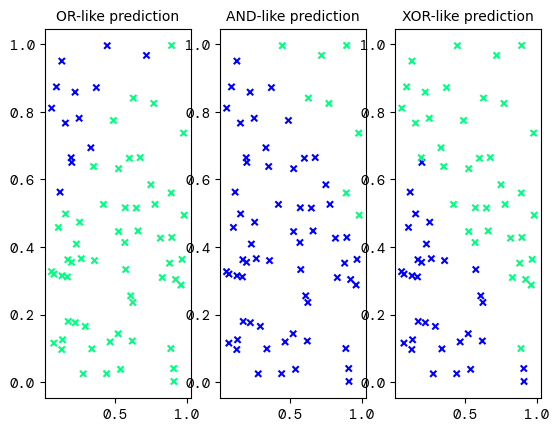

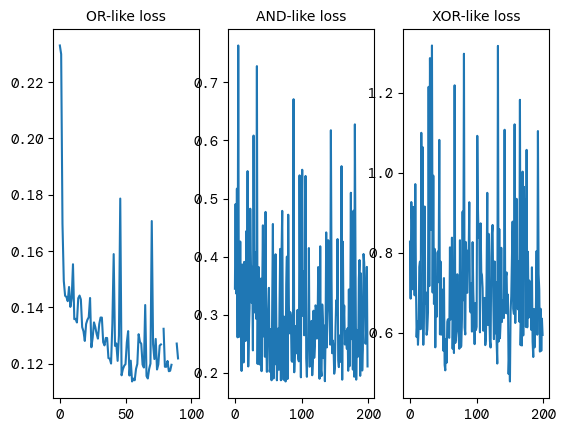

In [345]:
def predict(activations):
    return np.round(activations)


y_or = forward_propagate(params_or, x)[-1]
y_and = forward_propagate(params_and, x)[-1]
y_xor = forward_propagate(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
plt.show()

### One hidden layer

In [346]:
sigmoid = ada.activations.sigmoid

sgd = NN(architecture=[[2,4, 1],[ sigmoid, sigmoid ]], eta=0.1, epochs=200, tol=0.001, optimizer='sgd', gamma=0.9)
backwards = backprop_one_hidden
loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test, batch_size=4)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test, batch_size=4)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test, batch_size=4)

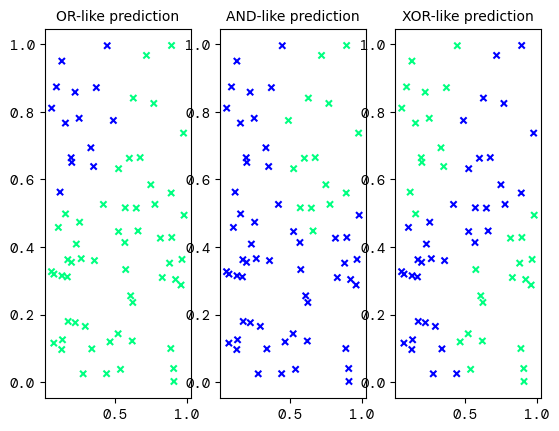

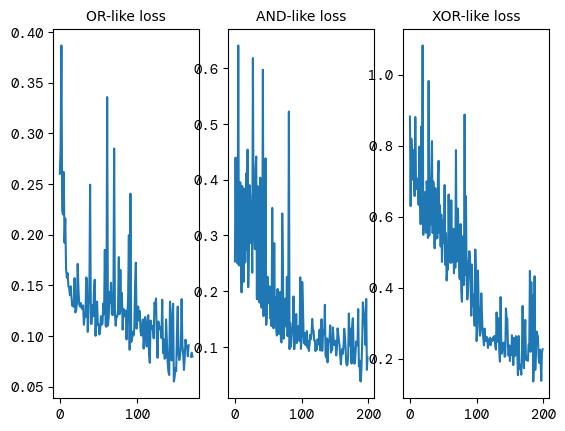

In [347]:
y_or = forward_propagate(params_or, x)[-1]
y_and = forward_propagate(params_and, x)[-1]
y_xor = forward_propagate(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
plt.show()